In [1]:
from scipy.special import expit
from rbmpy.rbm import RBM
from rbmpy.sampler import DirtyCorrectionMulDimSampler,VanillaSampler,ContinuousSampler,ContinuousApproxSampler, ContinuousApproxMulDimSampler, ApproximatedSampler, LayerWiseApproxSampler,ApproximatedMulDimSampler
from rbmpy.trainer import VanillaTrainier
from rbmpy.performance import Result
import numpy as np
import rbmpy.datasets, rbmpy.performance, rbmpy.plotter, pickle, rbmpy.rbm, os, logging, rbmpy.sampler,math
import math
from rbmpy.rbm import weights_into_hiddens
from rbmpy.progress import Progress

import rbmpy.plotter as pp
from numpy import newaxis
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

logger = logging.getLogger()
# Set the logging level to logging.DEBUG 
logger.setLevel(logging.INFO)

%matplotlib inline

In [2]:
from IPython.core.debugger import Tracer

In [3]:
#load the data
import glob
result_file_name = glob.glob("Results/2607241/*")


raw_data = []
for result in result_file_name:
    with open(result,"rb") as f:
        raw_data.append(pickle.load(f))

In [4]:
def get_data(size):
    mnist_data = dict()
    for i in range(1,10):
        ds = np.load("datasets/{}.npy".format(i))[:size]
        try:
            with open("models/{}_models".format(i), 'rb') as f:
                model = pickle.load(f)
            mnist_data[i] = (model, ds)
        except FileNotFoundError:
            logging.warn("There is no model for {}".format(i))
    return mnist_data

# Structure of data

```{(n,m) => {'ORBM_RECONS':..,'RBM_RECONS':..., 'model_ids':(n,m),'DS_COMP':... }}```



In [22]:


class Result(object):
    
    def __init__(self):
        self.orbm_a_recons = {}
        self.orbm_b_recons = {}
        self.rbm_a_recons  = {}
        self.rbm_b_recons  = {}
        
        self.orbm_a_scores = {}
        self.orbm_b_scores = {}
        self.rbm_a_scores = {}
        self.rbm_b_scores = {}
        
    def safe_add(self, key, value, score_dict):
        if key not in score_dict:
            score_dict[key] = []
        score_dict[key].append(value)
    
#   orbm_a_recons, orbm_b_recons,rbm_a_recons, rbm_b_recons ,orbm_a_score, orbm_b_score, rbm_a_score, rbm_b_score
    def add_scores(self,model_ids, orbm_a_recons, orbm_b_recons, rbm_a_recons, rbm_b_recons,orbm_a, orbm_b, rbm_a,rbm_b):
        self.safe_add(model_ids, orbm_a_recons, self.orbm_a_recons)
        self.safe_add(model_ids, orbm_b_recons, self.orbm_b_recons)
        self.safe_add(model_ids, rbm_a_recons, self.rbm_a_recons)
        self.safe_add(model_ids, rbm_b_recons, self.rbm_b_recons)
        
        self.safe_add(model_ids, orbm_a, self.orbm_a_scores)
        self.safe_add(model_ids, orbm_b, self.orbm_b_scores)
    
        self.safe_add(model_ids, rbm_a, self.rbm_a_scores)
        self.safe_add(model_ids, rbm_b, self.rbm_b_scores)
    
    def hightest_scores(key, n):
        """Grab the n highest values from the key thing"""
        pass
    
    
    def ndarrayify(self, score_dict):
        nd_score_dict = {}
        for key in score_dict:
            nd_score_dict[key] = np.array(score_dict[key])
        return nd_score_dict

    def mean_scores(self):
        or_a = self.ndarrayify(self.orbm_a_scores)
        or_b = self.ndarrayify(self.orbm_b_scores)
        r_a  = self.ndarrayify(self.rbm_a_scores)
        r_b  = self.ndarrayify(self.rbm_b_scores)

        or_a = {k: v.mean(axis = 0) for k, v in or_a.items()}
        or_b = {k: v.mean(axis = 0) for k, v in or_b.items()}
        r_a  = {k: v.mean(axis = 0) for k, v in r_a.items()}
        r_b  = {k: v.mean(axis = 0) for k, v in r_b.items()}
        
        return or_a, or_b, r_a, r_b
    
    def matrix_for_scores(self,scores):
        x_idx, y_idx = list(map(list, zip(*scores.keys())))

        matrix = np.ones(shape=(max(x_idx)+1, max(y_idx)+1))
        for key in scores:
            matrix[key[0],key[1]] = scores[key].sum()

        return matrix
    
    def mean_score_matrices(self):
        or_a, or_b, r_a, r_b = self.mean_scores()
        
        return self.matrix_for_scores(or_a), self.matrix_for_scores(or_b), self.matrix_for_scores(r_a), self.matrix_for_scores(r_b)
    
def ll_image_wise_score(v, v_prime):
#     return (v * np.log(v_prime)).sum(1)
    return -(abs(v - v_prime)).sum(1)
#     return (v * np.log(v_prime) + ((1 - v) * np.log((1 - v_prime))  )).sum(1)

    
def unzip_and_ndarrays(list_of_2d_tuple):
    a = list(map(list, zip(*list_of_2d_tuple)))
    return np.array(a[0]), np.array(a[1])
       
def scores_for_recons(target_recons,orbm_recons, rbm_recons):
    
    target_a_recons, target_b_recons = target_recons
    
    orbm_a_recons, orbm_b_recons = unzip_and_ndarrays(orbm_recons)
    rbm_a_recons, rbm_b_recons = unzip_and_ndarrays(rbm_recons)
    # Calculate the scores
    orbm_a_score = ll_image_wise_score(target_a_recons, orbm_a_recons)
    orbm_b_score = ll_image_wise_score(target_b_recons, orbm_b_recons)
    rbm_a_score = ll_image_wise_score(target_a_recons, rbm_a_recons)
    rbm_b_score = ll_image_wise_score(target_b_recons, rbm_b_recons)
    return orbm_a_recons, orbm_b_recons,rbm_a_recons, rbm_b_recons ,orbm_a_score, orbm_b_score, rbm_a_score, rbm_b_score

<img src = "Assets/LL_Score.png">

In [6]:
mnist_data = get_data(None)

In [7]:
def ds_from_mnist_ids(key, size):
    a_data = mnist_data[key[0]][1][:size]
    b_data = mnist_data[key[1]][1][:size]
    return rbmpy.datasets.flatten_data_set(a_data),rbmpy.datasets.flatten_data_set(b_data)

In [8]:
# # def scores_for_recons(target_recons,obrm_recons, rbm_recons, flattened_ds_comp)
# temp_orbm = raw_data[0][(1,1)]["ORBM_RECONS"] 
# temp_rbm = raw_data[0][(1,1)]["RBM_RECONS"]
# temp_ds_comp = raw_data[0][(1,1)]["DS_COMP"].reshape(temp_ds_comp.shape[0], temp_ds_comp.shape[1] * temp_ds_comp.shape[2])
# scores_for_recons((temp_ds_comp,temp_ds_comp),temp_orbm,temp_rbm, temp_ds_comp)[0].shape
# flattened_ds_comp = ds_comp.reshape(ds_comp.shape[0], ds_comp.shape[1] * ds_comp.shape[2])

In [23]:
result = Result()
for run in raw_data:
    for key in run:
        current_comp = run[key]
        orbm_recons = current_comp["ORBM_RECONS"]
        rbm_recons = current_comp["RBM_RECONS"]
        
        size = current_comp["DS_COMP"].shape[0]
        target_recons = ds_from_mnist_ids(key, size)
        result.add_scores(key, *scores_for_recons(target_recons, orbm_recons,rbm_recons))

In [24]:
a = result.mean_scores()
o_a, o_b, r_a, r_b = result.mean_score_matrices()

In [20]:
a[0][(1,3)].mean()
# a[1][(1,3)].mean()
# a[2][(1,3)].mean()
# a[3][(1,3)].mean()

-90.579622799694988

In [48]:
def plot_matrix(m, ticks):
    plt.imshow(m, interpolation='nearest',cmap=plt.cm.RdYlBu)
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.colorbar()
    plt.show()

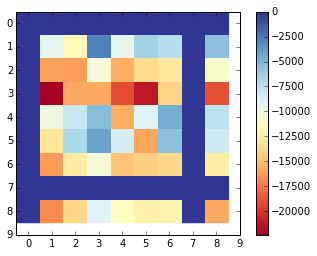

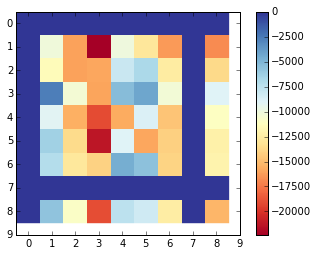

In [49]:
ticks = np.arange(10)
plot_matrix(o_a - r_a, ticks)
plot_matrix(o_b - r_b, ticks)

In [50]:
49 - np.where(np.isclose((o_b - r_b).T, (o_a - r_a)), 1,0).sum()


17

In [209]:
comp = (1,4)
or_score_of_interest = np.array(result.orbm_a_scores[comp])
or_recon_of_interest = np.array(result.orbm_a_recons[comp])

r_score_of_interest = np.array(result.rbm_a_scores[comp])
r_recon_of_interest = np.array(result.rbm_a_recons[comp])

or_max_idx = np.unravel_index(or_score_of_interest.argmax(), or_score_of_interest.shape)
# r_max_idx  = np.unravel_index(r_score_of_interest.argmax(), r_score_of_interest.shape)

# pp.image(or_recon_of_interest[or_max_idx[0], or_max_idx[1], :].reshape(28,28))
# pp.image(r_recon_of_interest[r_max_idx[0], or_max_idx[1], :].reshape(28,28))
# # pp.image(mnist_data[comp[0]][1][or_max_idx[1]])
# target = mnist_data[comp[0]][1][or_max_idx[1]]
# van_sampler = ContinuousSampler(mnist_data[comp[0]][0])
# pp.image(van_sampler.reconstruction_given_visible(target.reshape(28 * 28)).reshape(28, 28))

In [210]:
# or_score_of_interest[run].argsort()
or_score_of_interest[run][np.flipud(or_score_of_interest[run].argsort())]

array([ -23.94823587,  -27.14674114,  -36.36781219,  -36.4093732 ,
        -37.45871779,  -38.54047368,  -40.08777395,  -47.25927944,
        -48.03084792,  -48.07194336,  -49.07533639,  -49.1299418 ,
        -49.15037353,  -50.48390031,  -51.93908196,  -54.66777487,
        -56.05652203,  -56.06878095,  -57.10554845,  -57.83453882,
        -57.91005093,  -58.92792325,  -59.18511186,  -59.23077391,
        -59.64318871,  -59.96568038,  -60.27390853,  -60.80924476,
        -61.51885838,  -61.90612121,  -62.27735656,  -65.17545811,
        -66.25575878,  -66.5729074 ,  -67.16614859,  -67.37378922,
        -67.62916776,  -68.53249008,  -69.28128326,  -70.12096539,
        -70.20327673,  -71.21464234,  -71.71561293,  -71.75572074,
        -71.9371676 ,  -72.18456674,  -72.59957914,  -73.9206005 ,
        -76.15975759,  -76.7953917 ,  -78.61422234,  -80.6999098 ,
        -81.3254028 ,  -82.837887  ,  -83.0176658 ,  -84.23153609,
        -84.60051671,  -84.9753383 ,  -85.97375022,  -86.58078

orbm -23.948235865508003
rbm -51.856684133835984


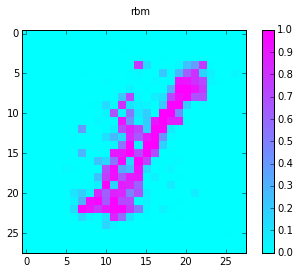

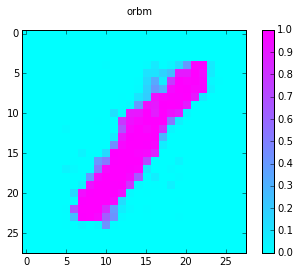

orbm -27.14674113554376
rbm -25.74934772465047


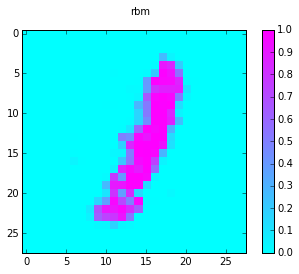

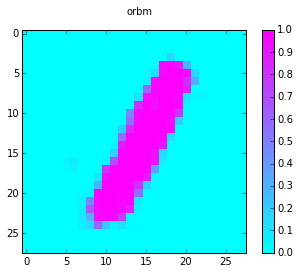

orbm -36.36781219455614
rbm -68.40235538421821


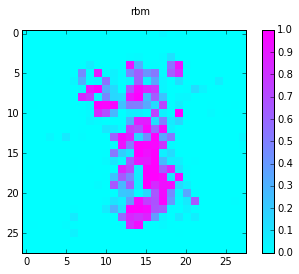

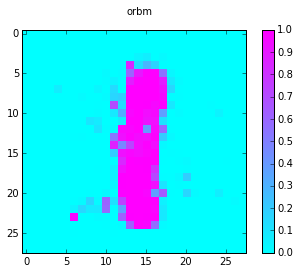

In [211]:
run = 0
range = 3
idx = np.flipud(or_score_of_interest[run].argsort())[:range]
idx
or_recon_of_interest[0].shape
for i in idx:
    print("orbm {}".format(or_score_of_interest[run][i]))
    print("rbm {}".format(r_score_of_interest[run][i]))
    plt.suptitle("rbm")
    pp.image(r_recon_of_interest[run,i].reshape(28,28))
    plt.suptitle("orbm")
    pp.image(or_recon_of_interest[run,i].reshape(28,28))

In [152]:
a = or_recon_of_interest[or_max_idx].reshape(28,28)
b = r_recon_of_interest[or_max_idx].reshape(28,28)
t = ds_from_mnist_ids(comp,size=200)[0][or_max_idx[1]].reshape(28,28)

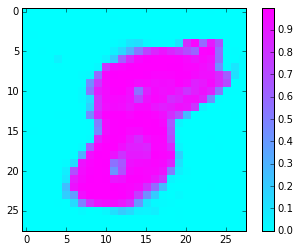

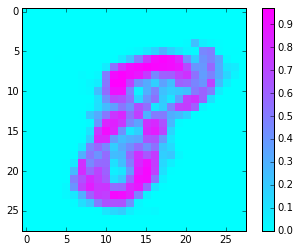

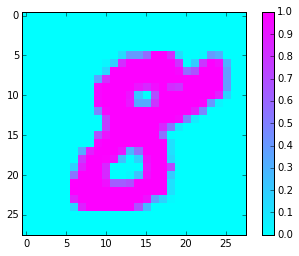

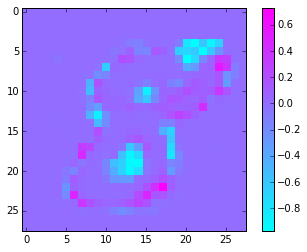

52.491884934
102.396403681


-52.491884933971448

In [153]:
pp.image(a)
pp.image(b)
pp.image(t)
pp.image(t-a)
print(abs(t - a).sum())
print(abs(t - b).sum())
or_score_of_interest[or_max_idx]

In [140]:
or_score_of_interest.max()


-58.464948757081892

In [21]:
or_score_of_interest.mean(axis=0)

(200,)

In [17]:
np.where(or_score_of_interest == or_score_of_interest.max())

(array([0, 2, 5, 7, 8, 9]), array([60, 60, 60, 60, 60, 60]))

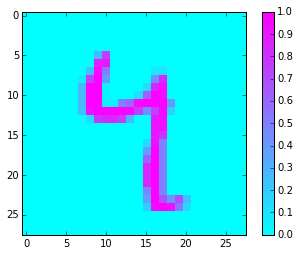

In [26]:
pp.image(mnist_data[comp[0]][1][r_max_idx[1]])

In [24]:
or_max_idx

(0, 188, 133)

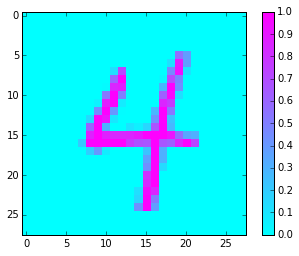

In [29]:
pp.image(target)

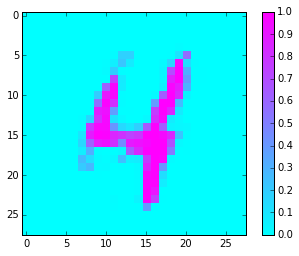

In [42]:
or_score_of_interest.max()

-6.9059495194763244e-10

In [43]:
or_score_of_interest

array([[[ -3.03713022e-05,  -1.54252513e-04,  -2.40082971e-04, ...,
          -1.68089815e-05,  -5.96995206e-04,  -4.48597462e-04],
        [ -5.79130727e-07,  -5.58712707e-06,  -5.91070871e-05, ...,
          -1.66157926e-05,  -3.16395664e-05,  -5.13741209e-06],
        [ -5.67308601e-03,  -7.44768904e-03,  -2.05336183e-02, ...,
          -3.45651148e-04,  -6.69159638e-03,  -1.37632418e-03],
        ..., 
        [ -1.42700396e-04,  -4.76571237e-04,  -4.64696517e-03, ...,
          -3.63598518e-04,  -1.23335786e-03,  -3.05107435e-04],
        [ -1.63138778e-06,  -1.18822099e-05,  -1.47820986e-04, ...,
          -2.46468989e-05,  -2.83299699e-04,  -1.39264575e-05],
        [ -1.77614688e-06,  -5.84941767e-05,  -2.21388133e-03, ...,
          -2.79140084e-03,  -2.66483006e-04,  -1.30255597e-04]],

       [[ -2.68780314e-05,  -2.36342946e-04,  -1.04089222e-04, ...,
          -8.93802805e-06,  -2.36944137e-04,  -1.79750867e-04],
        [ -5.79130727e-07,  -5.58712707e-06,  -5.91070871e-0

In [108]:
print("orbm{}".format(np.array(result.orbm_a_scores[(1,2)]).mean(0).max()))
print("rbm{}".format(np.array(result.rbm_a_scores[(1,2)]).mean(0).max()))

orbm-24.59749600406746
rbm-73.30987688913888


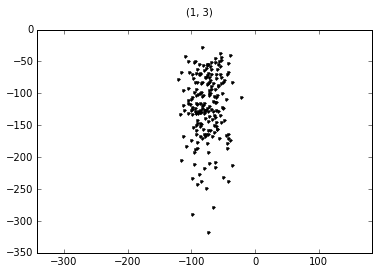

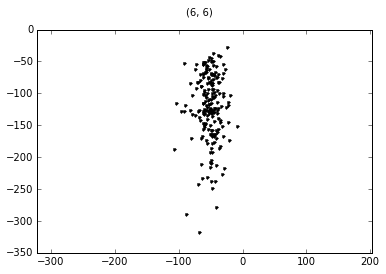

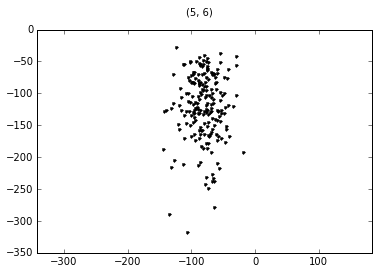

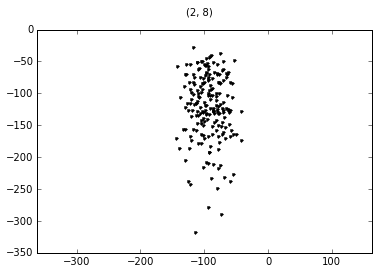

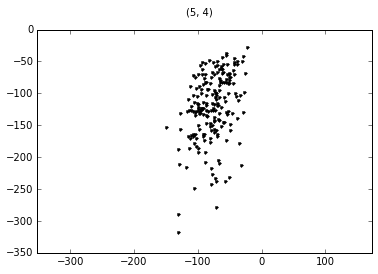

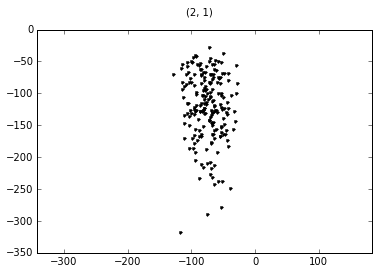

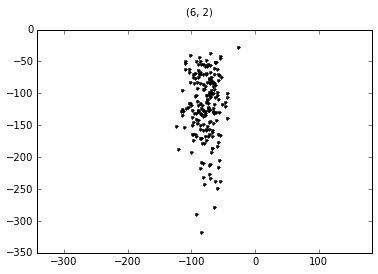

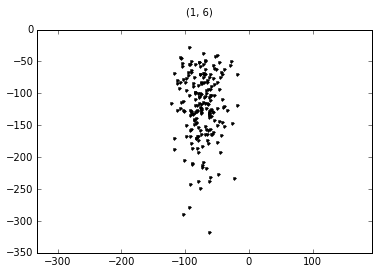

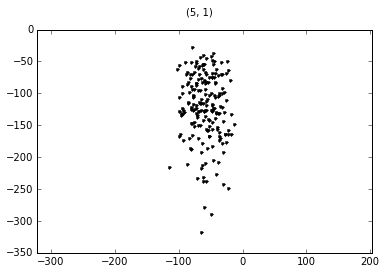

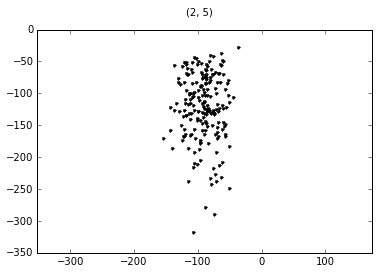

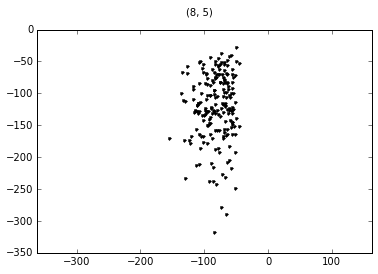

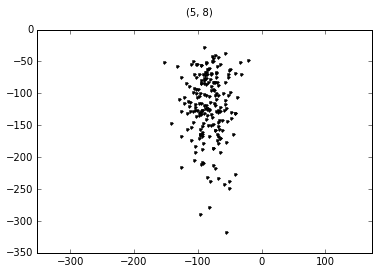

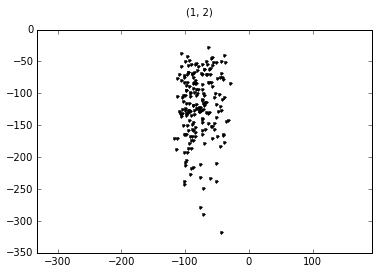

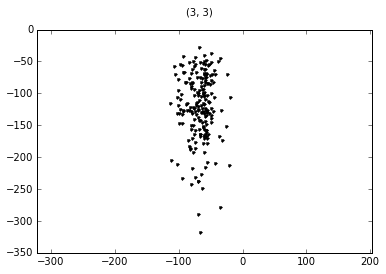

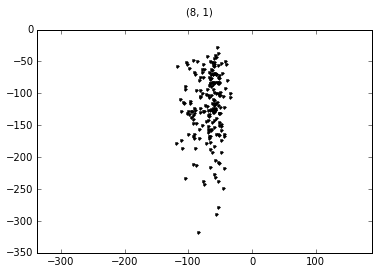

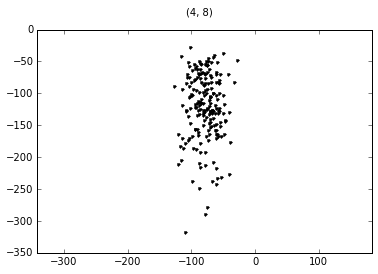

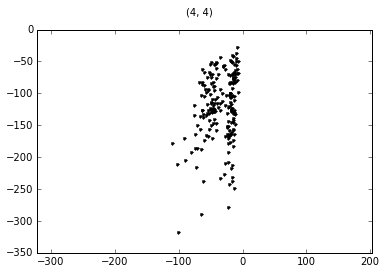

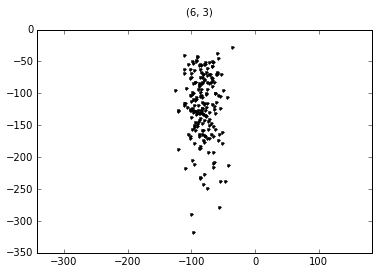

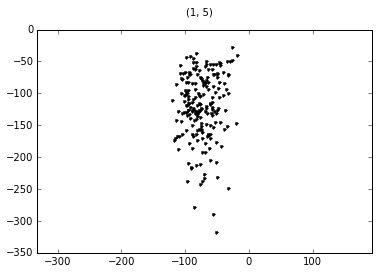

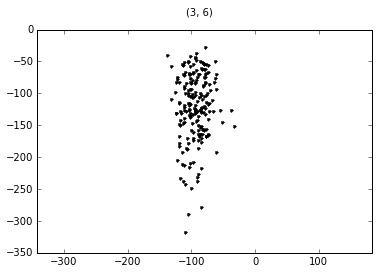

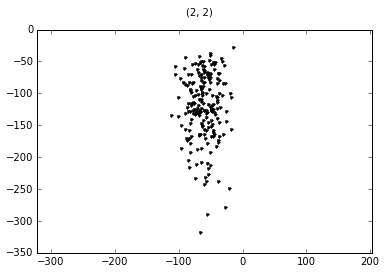

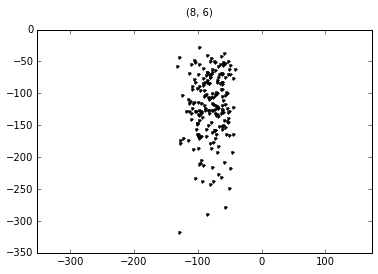

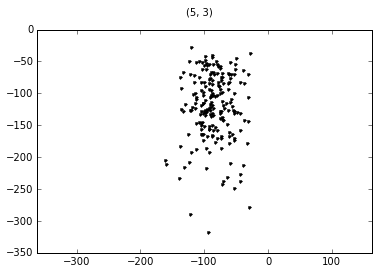

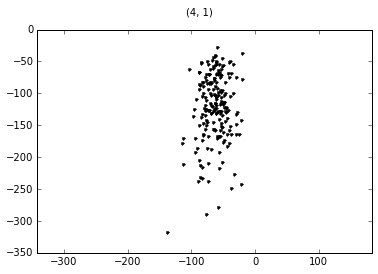

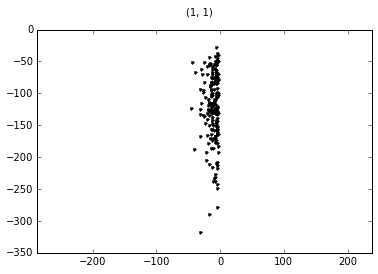

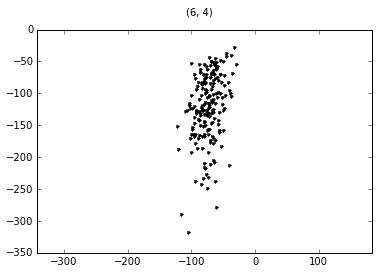

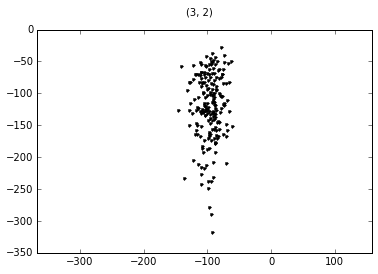

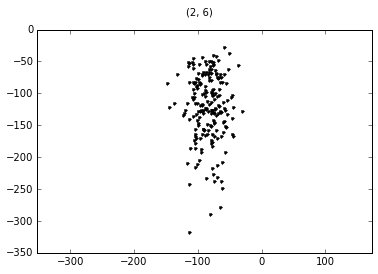

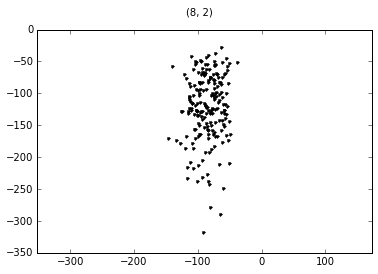

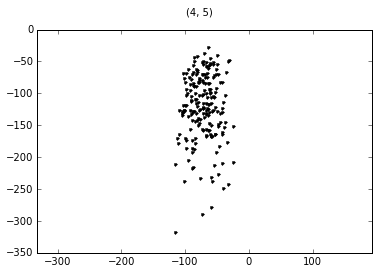

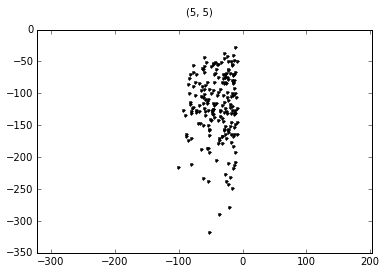

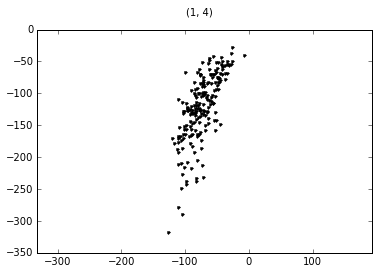

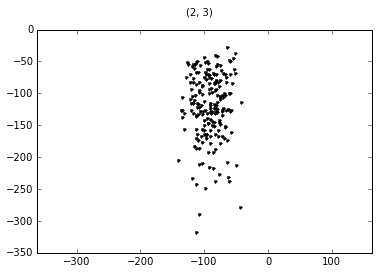

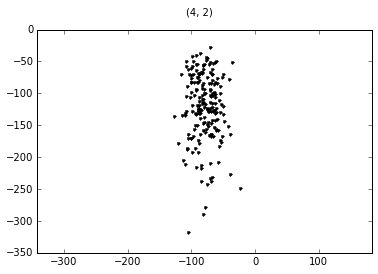

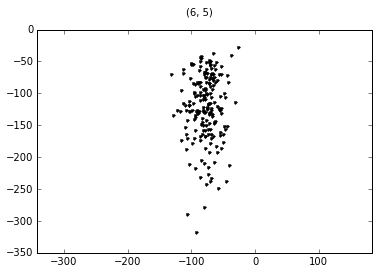

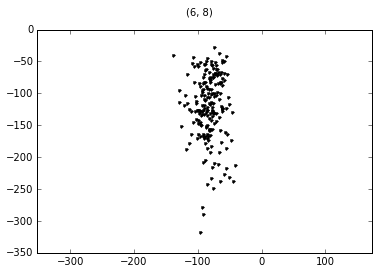

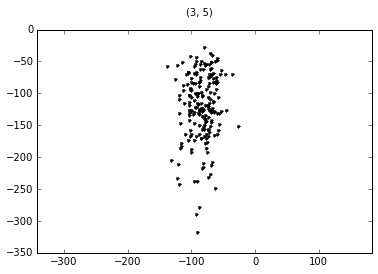

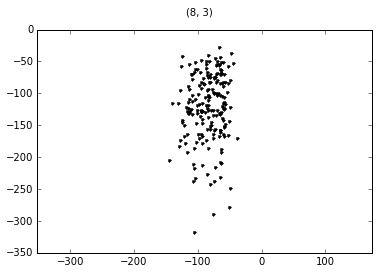

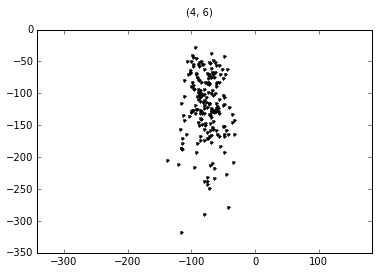

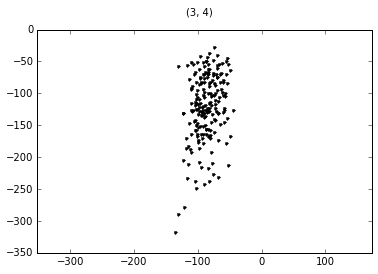

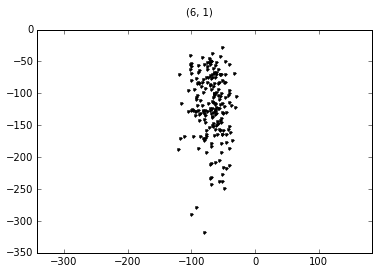

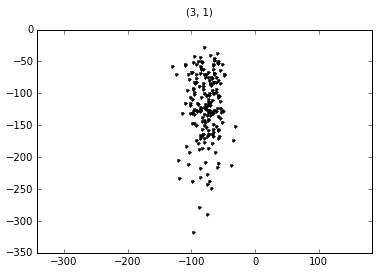

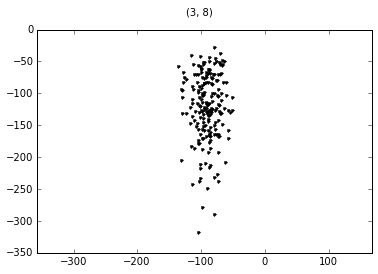

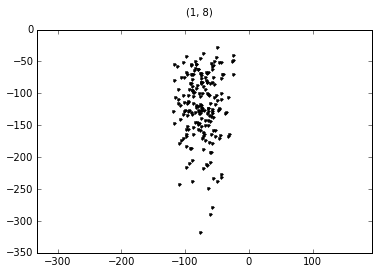

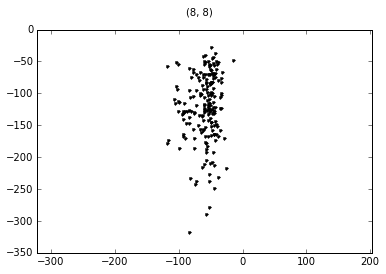

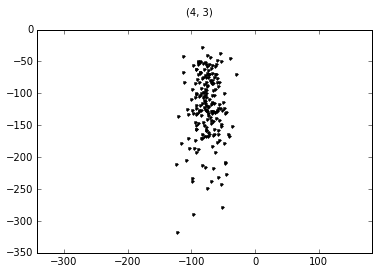

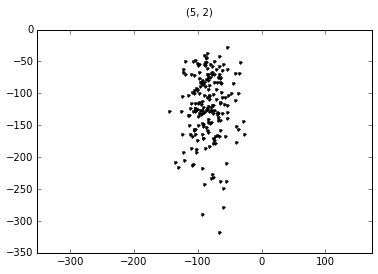

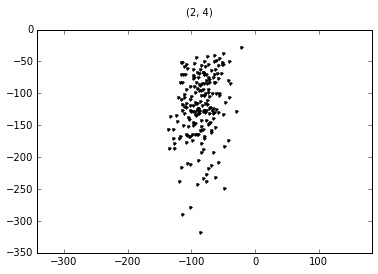

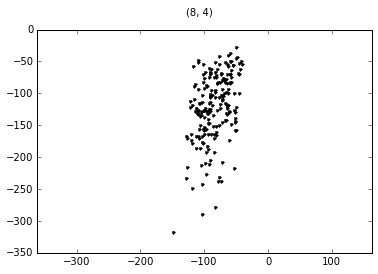

In [212]:
# comp = (3,2)
for key in result.rbm_a_scores.keys():
    plt.suptitle("{}".format(key))
    plt.plot(np.array(result.rbm_a_scores[key]).mean(0), np.array(result.orbm_a_scores[comp]).mean(0),'.k')
    plt.axis('equal')
    plt.show()


In [120]:
np.array(result.orbm_a_scores[comp])[0].shape

(200,)